In [1]:
import numpy as np
import sys
sys.path.append("../../src/")
import utility
import pandas as pd

from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import ttest_ind

from scipy.stats import kruskal
from statsmodels.stats.proportion import proportions_chisquare

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib

import statsmodels.api as sm

from scipy import stats

import pandas as pd

import math


In [2]:
df_IEA_train = pd.read_csv("../../output/IEA_train.csv").set_index("sid")
df_IEA_test = pd.read_csv("../../output/IEA_test.csv").set_index("sid")



In [3]:
df = utility.load_longitudinal()
covariances = ["Age_P2", "gender", "race", 
               "smoking_status_P2", 
               "BMI_P2", "ATS_PackYears_P2",
               "FEV1pp_utah_P2", "FEV1_FVC_utah_P2", 
               "SGRQ_scoreTotal_P2", "MMRCDyspneaScor_P2", 
               "distwalked_P2", "Frequent_Exacerbator_P2",
               "Perc15_Insp_Thirona_P2","pctEmph_Thirona_P2", "pctGasTrap_Thirona_P2", "Pi10_Thirona_P2", 
               "WallAreaPct_seg_Thirona_P2", "perc15_ratio", 
               "delta_FEV1pp_P2P3", "delta_FEV1FVC_P2P3",
               "Frequent_Exacerbator_P3", "5-year Mortality_P2", 
               "finalGold_P2"
           ] 



/ocean/projects/asc170022p/juc91/anaconda/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/ocean/projects/asc170022p/juc91/anaconda/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/ocean/projects/asc170022p/juc91/anaconda/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [4]:
cov_label = [iii.replace("Frequent_Exacerbator_P2", "Frequent Exacerbator (History)")\
             .replace("Frequent_Exacerbator_P3", "Frequent Exacerbator (Future)")\
             .replace("smoking_status_P2", "%Current Smoker").replace("_P2", "").replace("P3", "")\
             .replace("ATS_", "").replace("_Thirona", "").replace("FEV1pp_utah", "FEV$_1$%predicted")\
             .replace("FEV1_FVC_utah", "FEV$_1$/FVC").replace("distwalked", "6-Minute-Walk Distance").replace("pctEmph", "%Emphysema at -950HU")\
             .replace("Perc15_Insp", "perc15").replace("pctGasTrap", "%Gas Trapping").replace("gender", "Gender, %females")\
             .replace("race", "Race, %African-American").replace("PackYears", "Pack Years").replace("WallAreaPct_seg", "%WA segmental")\
             .replace("BMI", "Body Mass Index (BMI)").replace("Pi10", "Pi10").replace("SGRQ_scoreTotal", "SGRQ Total Score")\
             .replace("MMRCDyspneaScor", "mMRC Dyspnea Score")\
             .replace("FEV1pp", "FEV$_1$%predicted").replace("FEV1FVC", "FEV$_1$/FVC").replace("WApct", "%WA segmental")\
             .replace("delta_", "$\Delta$")\
             .replace("perc15_ratio", "$Q_{perc15_{peel-core}}$")
             for iii in covariances]

In [5]:
df_train = pd.merge(df_IEA_train, df, left_index = True, right_index = True)
df_test = pd.merge(df_IEA_test, df, left_index = True, right_index = True)

In [6]:
mean_train = df_train[covariances].mean()
mean_train["gender"] = mean_train["gender"] - 1
mean_train["race"] = mean_train["race"] - 1
mean_train["smoking_status_P2"] = mean_train["smoking_status_P2"] - 1
std_train = df_train[covariances].std()


mean_test = df_test[covariances].mean()
mean_test["gender"] = mean_test["gender"] - 1
mean_test["race"] = mean_test["race"] - 1
mean_test["smoking_status_P2"] = mean_test["smoking_status_P2"] - 1
std_test = df_test[covariances].std()

In [7]:
val = []
for ccc in covariances[:-1]:
    C1 = df_train[ccc].to_numpy()
    C1 = C1[~np.isnan(C1)]
    C2 = df_test[ccc].to_numpy()
    C2 = C2[~np.isnan(C2)]
    
    if ccc == "gender" or ccc == "race" or ccc == "smoking_status_P2" \
    or ccc == "Frequent_Exacerbator_P2" or ccc == "Frequent_Exacerbator_P3" \
    or ccc == "5-year Mortality_P2": 
        p_val = proportions_chisquare( [(C1 == 1).sum(), (C2 == 1).sum()], [len(df_train), len(df_test)] )[1]
    else:
        p_val = kruskal(C1, C2).pvalue
    
    
    
    if ccc == "gender" or ccc == "race" or ccc == "smoking_status_P2" \
    or ccc == "Frequent_Exacerbator_P2" or ccc == "Frequent_Exacerbator_P3" \
     or ccc == "5-year Mortality_P2": 
        tmp = ["{:.1f}%".format(mean_train[ccc] * 100), 
                    "{:.1f}%".format(mean_test[ccc] * 100)]
    elif ccc == "distwalked_P2" or ccc == "Perc15_Insp_Thirona_P2":
        tmp = ["{:.1f} $\pm$ {:.1f}".format(mean_train[ccc], std_train[ccc]), 
                    "{:.1f} $\pm$ {:.1f}".format(mean_test[ccc], std_test[ccc])
                   ]
    else:
        tmp = ["{:.1f} $\pm$ {:.1f}".format(mean_train[ccc], std_train[ccc]), 
                    "{:.1f} $\pm$ {:.1f}".format(mean_test[ccc], std_test[ccc])
                   ]
    
    tmp.append( "{:.3f}".format(p_val) )
                     
    val.append(tmp)
    
row_labels = cov_label.copy()[:-1]
    
for ggg in [0,1,2,3,4,-1]:
    if ggg == -1:
        row_labels.append("%PRISm")
    else:
        row_labels.append("%GOLD {}".format(ggg))
        
    
    C1 = df_train["finalGold_P2"].to_numpy()
    C1 = C1[~np.isnan(C1)]
    C2 = df_test["finalGold_P2"].to_numpy()
    C2 = C2[~np.isnan(C2)]
    
    tmp = ["{:.2f}%".format( (C1 == ggg).sum() / len(C1) * 100), 
                    "{:.2f}%".format( (C2 == ggg).sum() / len(C2) * 100) ]
    
    
    p_val = proportions_chisquare( [(C1 == ggg).sum(), (C2 == ggg).sum()], [len(C1), len(C2)] )[1]
    tmp.append( "{:.3f}".format(p_val) )
    
    val.append(tmp)
    

In [8]:
col_labels = [ "Training", "Held-out", "p-values" ]

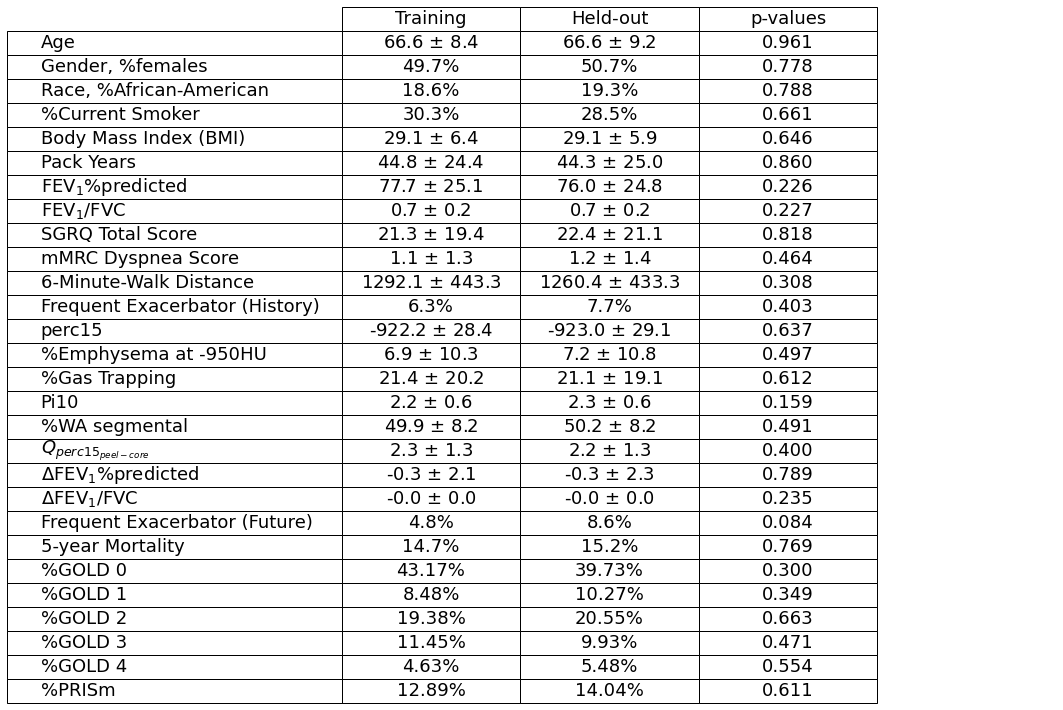

In [9]:
str_val = np.array(val, str)

plt.figure(figsize=(16,12))
the_table=plt.table(cellText=str_val, rowLabels=row_labels, colLabels = col_labels,
                    colWidths = [.1]*str_val.shape[1], loc='center',cellLoc = "center")
plt.axis('off')
the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)